In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from category_encoders import TargetEncoder
from sklearn.preprocessing import MinMaxScaler

from xgboost import XGBRegressor
from sklearn.model_selection import GridSearchCV, learning_curve
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

In [2]:
rumah123_df = pd.read_csv("../../data/rumah123_ready.csv")
X = rumah123_df.drop(columns=["price"])
y = rumah123_df["price"]
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

In [3]:
encoder = TargetEncoder(cols=["location"])
encoder.fit(X_train, y_train)

X_train_encoded = encoder.transform(X_train)
X_test_encoded = encoder.transform(X_test)

In [4]:
scaler = MinMaxScaler()
X_train_scaled = scaler.fit_transform(X_train_encoded)
X_test_scaled = scaler.transform(X_test_encoded)

In [5]:
xgb = XGBRegressor(verbosity=0)

param_grid = {
    "n_estimators": [100, 500, 100],  # 100, 500, 1000
    "learning_rate": [0.01, 0.03, 0.1],  # 0.03, 0.04, 0.05
    "max_depth": [6, 7, 8, 9, 10],  # 7, 8, 9
    "subsample": [0.5, 0.8, 1],  # 0.8, 0.9, 1.0
    "colsample_bytree": [0.5, 0.8, 1],  # 0.7, 0.8, 0.9
}

In [6]:
grid_search = GridSearchCV(
    estimator=xgb,
    param_grid=param_grid,
    scoring="neg_mean_squared_error",
    cv=5,
    n_jobs=-1,
    verbose=3,
)

grid_search.fit(X_train_scaled, y_train)

print("Best parameters:", grid_search.best_params_)

Fitting 5 folds for each of 405 candidates, totalling 2025 fits
Best parameters: {'colsample_bytree': 0.8, 'learning_rate': 0.03, 'max_depth': 9, 'n_estimators': 500, 'subsample': 0.8}


In [7]:
# Fit & predict
best_xgb = XGBRegressor(**grid_search.best_params_)
best_xgb.fit(X_train_scaled, y_train)
y_train_pred = best_xgb.predict(X_train_scaled)
y_test_pred = best_xgb.predict(X_test_scaled)

In [8]:
# Hitung metrik
mae_train = mean_absolute_error(y_train, y_train_pred)
mae_test = mean_absolute_error(y_test, y_test_pred)
mse_train = mean_squared_error(y_train, y_train_pred)
mse_test = mean_squared_error(y_test, y_test_pred)
rmse_train = np.sqrt(mse_train)
rmse_test = np.sqrt(mse_test)
r2_train = r2_score(y_train, y_train_pred)
r2_test = r2_score(y_test, y_test_pred)

In [9]:
# Buat dict berisi (Train, Test) untuk setiap metrik
metrics = {
    "MAE": (mae_train, mae_test),
    "MSE": (mse_train, mse_test),
    "RMSE": (rmse_train, rmse_test),
    "R²": (r2_train, r2_test),
}

df_eval = pd.DataFrame.from_dict(metrics, orient="index", columns=["Train", "Test"])

df_eval

,Train,Test
MAE,125.924940,193.692143
MSE,29127.168934,67099.246299
RMSE,170.666836,259.035222
R²,0.875027,0.721094


In [10]:
def plot_learning_curve(model, X, y, cv, scoring, title):
    train_sizes, train_scores, test_scores = learning_curve(
        model, X, y, cv=cv, scoring=scoring
    )
    train_scores_mean = -np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = -np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)

    plt.figure(figsize=(10, 6))
    plt.title(title)
    plt.xlabel("Number of Training Samples")
    plt.ylabel("neg_mean_squared_error")
    plt.grid()

    plt.fill_between(
        train_sizes,
        train_scores_mean - train_scores_std,
        train_scores_mean + train_scores_std,
        alpha=0.1,
        color="r",
    )
    plt.fill_between(
        train_sizes,
        test_scores_mean - test_scores_std,
        test_scores_mean + test_scores_std,
        alpha=0.1,
        color="g",
    )
    plt.plot(train_sizes, train_scores_mean, "o-", color="r", label="Training RMSE")
    plt.plot(train_sizes, test_scores_mean, "o-", color="g", label="Testing RMSE")

    plt.legend(loc="best")
    plt.show()

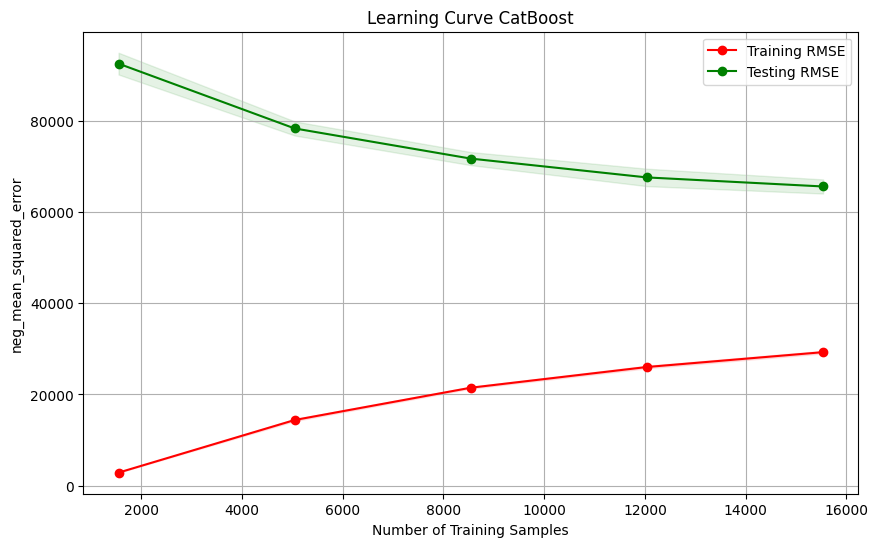

In [11]:
# Gabungkan array menjadi satu
X_scaled = np.vstack([X_train_scaled, X_test_scaled])

# Gabungkan y
y = pd.concat([y_train, y_test], axis=0).reset_index(drop=True)

# Buat DataFrame dari array X_scaled
X = pd.DataFrame(X_scaled, columns=[X_train.columns])

plot_learning_curve(
    best_xgb,
    X,
    y,
    cv=5,
    scoring="neg_mean_squared_error",
    title="Learning Curve CatBoost",
)